***LSTM Version of the chatbot***

The following code install the dependencies & import the necessary libraries listed below.   

Installations
1. nltk  - It is a natural language processing toolkit.
2. scikit-learn - It is a ML library that supports model training, evaluation etc
3. faiss-cpu - It is a facebook library for fast similarity search and clustering.
4. bert-score - Evaluation metric for text similarity using BERT embeddings
5. transformers -



In [36]:
!pip install nltk scikit-learn faiss-cpu bert-score transformers

The following code import the necessary libraries listed below.    

1. os - library to del with input ooutput functionalities like file read and write
2. json - library to support json parsing and serialization
3. time - to measure excution time
4. numpy - for numerical computation like handling arrays
5. torch - for building neural network layers and loss functions
6. collections - data structure or container to count word frequency
7. cosine_similarity - compute Cosine similarity between vectors
8. word_tokenize - for tokenization of words.
9. sentence_bleu  - calculate bleu score for text similarity
10. SmoothingFunction - provide smoothing methods  
11. bert_score  - to compute semantic similarity scores using bert embeddings.
12. nltk punkt - download nltk pretrained tokeniser model.
13. nltk punkt tab -

In [91]:
import os
import json
import time
import torch
import numpy as np
import torch.nn as nn
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score
import torch.nn.functional as F

# for visulizations
from wordcloud import WordCloud
import matplotlib.pyplot as plt_lstm
import matplotlib
from collections import Counter

import requests

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

#Part-1 Data Preprocessing and model training

**1.1 Data Collection**

Below code fetches data by loopinig through,the training data files (json file) from a particular location and populates a list variable with questions and answers pair.

In [92]:
'''Input folder path - in this case it is google colab notebook directory path.
In case of python code file it will be changed local system or github path '''

github_url_training  = "https://raw.githubusercontent.com/sandeepkumar-84/DBS/dbs_applied_research_project_v1/AppliedResearch/Working%20v1/LSTM%20Version/Training_set_v2.json"
folder_path_training = "/content/Research-Chatbot/Training"

# variable that holds the question answers pairs extracted from the json input file.
qa_pairs_combined_raw = []

'''loop through each file that ends with json extenstion in the directory, read the file and load the data into the temporary list variable
if the data obtained is not a list that pair will be skipped. Else it will be appended to another global variable qa_pairs_combined_raw
whole loop is wrapped in the try cactch block so that in case of any exception it can be raised or printed'''

def load_github_file(file_url):
    try:
        response = requests.get(file_url)
        if response.status_code == 200:
            qa_list = response.json()
            if isinstance(qa_list, list):
                qa_pairs_combined_raw.extend(qa_list)
                print(f"QA Pairs Loaded {len(qa_list)} from GitHub file: {file_url}")
                return True
            else:
                print(f"Skipping GitHub file {file_url}: not a list of QA pairs.")
        else:
            print(f"GitHub file not found: {file_url} (status code {response.status_code})")
    except Exception as e:
        print(f"Error reading GitHub file {file_url}: {e}")
    return False

def load_local_files():
  for file_name in os.listdir(folder_path_training):
      file_path_training = os.path.join(folder_path_training, file_name)
      if file_name.endswith('.json'):
          try:
              with open(file_path_training, 'r', encoding='utf-8', errors='ignore') as f:
                  qa_list = json.load(f)
                  if isinstance(qa_list, list):
                      qa_pairs_combined_raw.extend(qa_list)
                      print(f" QA Pairs Loaded {len(qa_list)} from file : {file_name}")
                  else:
                      print(f"Skipping the file {file_name}: as its is not a list of QA pairs.")
          except json.JSONDecodeError:
              print(f"error in reading the JSON file : {file_name}")
          except Exception as e:
              print(f"error reading {file_name}: {e}")
      else:
          print(f"Skipping non-JSON file: {file_name}")



if not load_github_file(github_url_training):
    load_local_files(folder_path_training)

qa_pairs = qa_pairs_combined_raw

print(f"total QA pairs loaded: {len(qa_pairs)}")


QA Pairs Loaded 349 from GitHub file: https://raw.githubusercontent.com/sandeepkumar-84/DBS/dbs_applied_research_project_v1/AppliedResearch/Working%20v1/LSTM%20Version/Training_set_v2.json
total QA pairs loaded: 349


below plot shows the wordcloud representation of the training data. The font size and the dark font color represent the higher frequency of that wordin the training data.

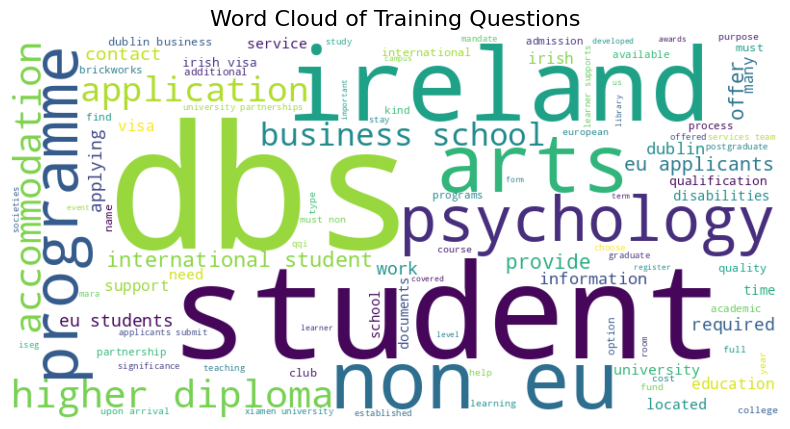

In [93]:
all_text = " ".join([q["query"].lower() for q in qa_pairs_combined_raw])


wordcloud_alltext = WordCloud(width=800, height=400, background_color='white',
                      colormap='viridis', max_words=100).generate(all_text)


plt_lstm.figure(figsize=(10, 5))
plt_lstm.imshow(wordcloud_alltext, interpolation='bilinear')
plt_lstm.axis('off')
plt_lstm.title("Word Cloud of Training Questions", fontsize=16)
plt_lstm.show()


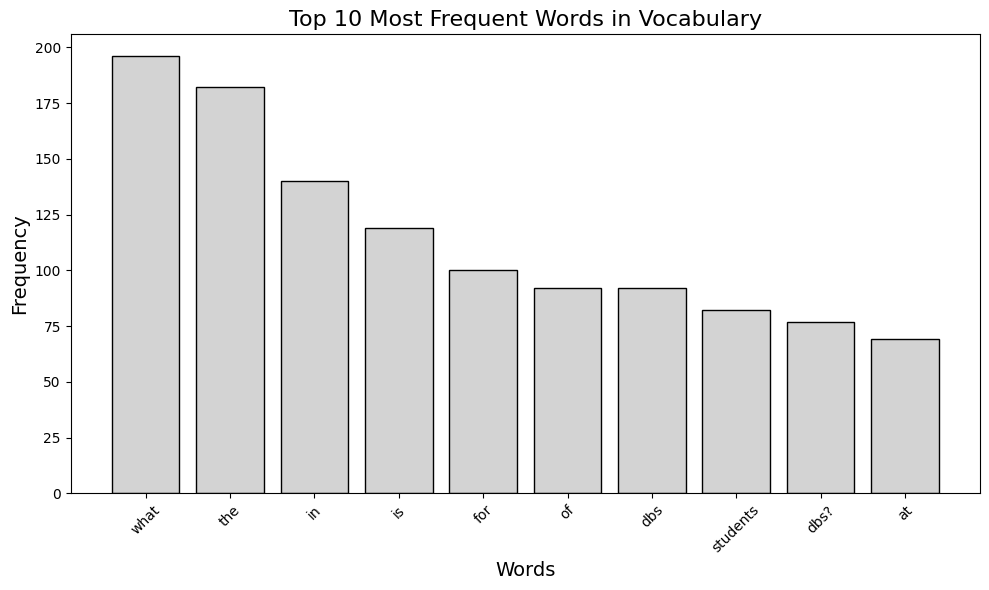

In [94]:
all_words = all_text.split()
word_freq = Counter(all_words)
top_words = word_freq.most_common(10)
words, counts = zip(*top_words)
plt_lstm.figure(figsize=(10, 6))
plt_lstm.bar(words, counts, color='lightgrey', edgecolor='black')
plt_lstm.title("Top 10 Most Frequent Words in Vocabulary", fontsize=16)
plt_lstm.xlabel("Words", fontsize=14)
plt_lstm.ylabel("Frequency", fontsize=14)
plt_lstm.xticks(rotation=45)
plt_lstm.tight_layout()
plt_lstm.show()

**1.2 Data cleaning** - text normalization through lowercasing and triming    whitespaces.

**1.3 Tokenization** - Word level tokenization through NLTK word tokenization. It is used for building vocabolary and from all training questions and encoding user query.

**1.4 Vocabulary Creation** - vocab is created using all unique words in the training questions. special tokens are added for unknown words and for sequence padding.

**1.5 Encoding & Padding** - encoding function tokenizes input question, convert tokens to id from vocab, pads or truncates sequence to fixed length of max 20 and retuns a pytocrch tensor.

Explanation of the code - It initializes the model parameters and prepares a datset of questions and answers. Then it builds a vocabolary from words in all the questions so that they can be coverted into vectors later by encoding function.  

In [95]:

# Defines the size of word embedding vectors
embedding_dim_lstm = 100
# number of hidden units in the hidden layers
hidden_dim_lstm = 128
#max length of the input sequence
max_len = 20

# dataset preperation where questions and anwers variables are populated using for in loop
questions = [q["query"].lower() for q in qa_pairs if "query" in q]
answers = [q["expected_answer"] for q in qa_pairs if "expected_answer" in q]

# Next step is to build the vocabulary using the word_tokenize nltk function for all the words in the question.
all_words = [word for q in questions for word in word_tokenize(q)]

# word frequency is calculated
word_freq = Counter(all_words)

# unique id starting from 2 is assigned to each word while 0 and 1 are kept for padding and unknown words
vocab = {word: i + 2 for i, (word, _) in enumerate(word_freq.items())}
vocab["<pad>"] = 0
vocab["<unk>"] = 1
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# function to return the padded tensors of the tokens.
def encode_question(q):
    tokens = word_tokenize(q.lower())
    idxs = [vocab.get(w, 1) for w in tokens]
    padded = idxs[:max_len] + [0] * (max_len - len(idxs))
    return torch.tensor(padded)


Vocabulary size: 642


below plot shows the wordcloud representation of the vocab data. The font size and the dark font color represent the higher frequency of that word in the vocab.

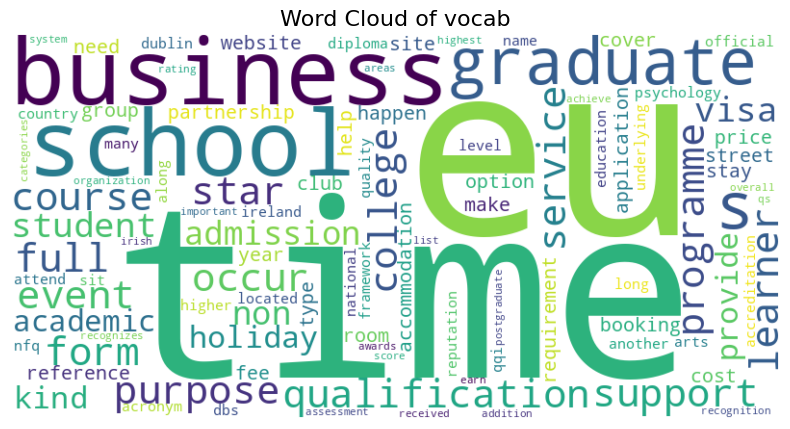

In [96]:

wordcloud_vocab = WordCloud(width=800, height=400, background_color='white',
                      colormap='viridis', max_words=100).generate(" ".join(vocab.keys()))

plt_lstm.figure(figsize=(10, 5))
plt_lstm.imshow(wordcloud_vocab, interpolation='bilinear')
plt_lstm.axis('off')
plt_lstm.title("Word Cloud of vocab", fontsize=16)
plt_lstm.show()

**1.6 Vectorization\Embeddings** - LSTM model includes an embedding layer which is initialized with vcab size and dimensions = 100.

**1.7 Model Definition (LSTM Encoder)** - embedding layer converts tokens into dense vectors, lstm layer is for capturing dependencies size-128 and fully connected layer transforms last hidden state to vector. this will give the dense vector representation of the query.  

Following code is a class whose functionality is to provide LSTM based encoder
Its init function sets the embedding layers, lstm layer and fuly converted layer

In [97]:
# torch library is utilized below.
class LSTMEncoderClass(nn.Module):
    def __init__(self, vocab_size, embedding_dim_lstm, hidden_dim_lstm):
        super(LSTMEncoderClass, self).__init__() # calling the base class constructor
        self.embedding = nn.Embedding(vocab_size, embedding_dim_lstm) # embedding layer to map word ids to vectors
        self.lstm = nn.LSTM(embedding_dim_lstm, hidden_dim_lstm, batch_first=True) # LSTM layer to catch semantic patterns
        self.fc = nn.Linear(hidden_dim_lstm, hidden_dim_lstm) # to transform hidden state fully connected layer is returned.

    def forward(self, input_ids):
        embedded = self.embedding(input_ids) # tokens are converted to embeddings
        _, (hidden, _) = self.lstm(embedded) # fetches final hidden state from LSTM
        return self.fc(hidden[-1])  # return the last hiddeb layer


**1.8 Precomputing Training Question Embeddings** - All training questions are encoded and passed through model in evaluation mode, embeddings are stored in a variable for cosine similarity lookups.
Below code encode all the questions and stacks them. Then initializes the LSTM model and generate vector embeddings.


In [98]:
encoded_questions = torch.stack([encode_question(q) for q in questions])

model = LSTMEncoderClass(vocab_size=vocab_size, embedding_dim_lstm=embedding_dim_lstm, hidden_dim_lstm=hidden_dim_lstm)
# Set the model to evaluation mode
model.eval()

# generate vector embeddings as float tensors for all encoded questions without tracking gradients
with torch.no_grad():
    question_vecs_tensor = model(encoded_questions).float()


Below code provides a sample chatbot functionality (non ui based) to test the above code.

User inputs query which is then lowercased and trimmed for whitespaces, it is then encoded and passed through model to get embeddings, cosine similarity is computed against precomputed training questions embeddings. torch argmax is used to get the best matching index. if the similarity score is less than the 0.6 then usr is returned with message that "sorry, i dont understand" otherwise the corresponding answer is returned.

In [99]:
''' lstm version of the chatbot functionality. While loop provides continues interaction until user inputs exit.
'''

def lstm_chatbot():
    print("DBS Specific LSTM Chatbot. Type 'exit' to quit.")
    while True:
        user_input = input("You: ").lower().strip() # read the user input and lowercae and trim them for any spaces for ideal comparison later
        if user_input in ['exit', 'quit']:
            print("DBS Chatbot: Goodbye!")
            break

        input_vec = encode_question(user_input).unsqueeze(0) # use above encode function to encode the user input
        with torch.no_grad():
            query_vec = model(input_vec).float() # generate embedding of the user query
            similarities = F.cosine_similarity(query_vec, question_vecs_tensor) #compare using cosine similarity
            best_idx = torch.argmax(similarities).item() # get the index of the most similar question
            best_score = similarities[best_idx].item() # get the smilarity score of the best match

        if best_score < 0.6: # if the score is less than standard 0.6 then user is prompted with appropriate message otherwise the generated response if returned
            print("DBS Chatbot: Sorry, I don't understand.")
        else:
            print("DBS Chatbot:", answers[best_idx])

Below code runs a test of the above chatbot function

In [100]:
# execute the function to start the sample chatbot
lstm_chatbot()


DBS Specific LSTM Chatbot. Type 'exit' to quit.
You: What is the name of Ireland's largest independent third-level college?
DBS Chatbot: The International Student Services Team helps international students with immigration services and advice.
You: When was DBS established?
DBS Chatbot: the Department of Education
You: When was DBS established?
DBS Chatbot: the Department of Education
You: exit
DBS Chatbot: Goodbye!


#Part-II Evaluation Pipeline
This section is focussed on the evaluation of the LST version of the DBS specific chatbot developed in the first part

**1.9 Model Evaluation** - Evaluation is performed using function evaluate_lstm_model(). It evaluate the lstm model and contains all the different evaluation parameters required for the overall benchmarking



*    Test set - contains the test data(json format). It has  question and expected answers pairs

*   model -

*   qa_pairs - full set of question answer pairs

*   vocab  - mapping of words to ids
*   max_len - max ecoding legth for tokens


*   question_vecs_tensor - pre computed embeddings for all training questions


*   threshold - float variable a cosine similarity threshold for considering a match


*  return - detailed result of the evaluation

Evaluation Metrics used are :

Exact Match Accuracy → proportion of exact match of the response generated with the expected.

BLEU Score → n-gram overlap using NLTK with smoothing.

BERTScore-F1 → It gives semantic similarity using pretrained BERT embeddings.

Average Response Time → per-query inference time.



In [101]:
'''
The function below evaluate the lstm model and contains all the different evaluation parameters required for the overall benchmarking



'''
def evaluate_lstm_model(test_set, model, qa_pairs, vocab, max_len, question_vecs_tensor, threshold=0.5):
    results = []
    total_time = 0
    all_generated = []
    all_expected = []

    model.eval()
    smoothie = SmoothingFunction().method4 #smoothing function is used so that even if there is not a perfect match, it provides score for partial match or reasonably correct response

    # for all the QnA pair in the test set
    for item in test_set:
        query = item["query"]
        expected = item["expected_answer"]

        start_time_lstm = time.time() # to track the inference time
        input_vec = encode_question(query).unsqueeze(0) # input query is encode into vector
        with torch.no_grad():
            query_embedding = model(input_vec).float() # get the corresponding embedding
            similarities = F.cosine_similarity(query_embedding, question_vecs_tensor) # get the cosine similarity
            best_match_index = torch.argmax(similarities).item() # get the best matching question
            best_score = similarities[best_match_index].item() # get the best similarity score

        if best_score >= threshold:
            generated = qa_pairs[best_match_index]["expected_answer"]
        else:
            generated = "I'm sorry, I don't know the answer."

        response_time_lstm = time.time() - start_time_lstm
        total_time += response_time_lstm

        # Exact Match is calculated for the accuracy
        exact_match = int(expected.lower() in generated.lower()) if expected else 0

        # BLEU Score is calculated
        bleu = sentence_bleu([expected.split()], generated.split(), smoothing_function=smoothie) if expected else 0.0

        # variable result is appended with the metrics calculated above
        results.append({
            "Query": query,
            "Generated": generated,
            "Expected": expected,
            "ExactMatch": exact_match,
            "BLEU": bleu,
            "TimeTaken": response_time_lstm
        })

        all_generated.append(generated)
        all_expected.append(expected)

    # empty expected answers are filtered out
    filtered_generated = [g for g, e in zip(all_generated, all_expected) if e.strip()]
    filtered_expected = [e for e in all_expected if e.strip()]

  # berts score is calculated
    if filtered_expected:
        P, R, F1 = bert_score(filtered_generated, filtered_expected, lang="en", verbose=True)
        avg_bertscore_f1 = F1.mean().item()
    else:
        avg_bertscore_f1 = 0.0


    accuracy_lstm = sum(r["ExactMatch"] for r in results) / len(results)
    avg_bleu_lstm = sum(r["BLEU"] for r in results) / len(results)
    avg_time_lstm = total_time / len(results)

    print("\n--- Evaluation Summary ---")
    print(f"Accuracy (Exact Match): {accuracy_lstm:.2f}")
    print(f"Average BLEU Score: {avg_bleu_lstm:.2f}")
    print(f"Average BERTScore F1: {avg_bertscore_f1:.2f}")
    print(f"Average Response Time: {avg_time_lstm:.2f}s")

    return results


sample test set

test_set = [
    {"query": "What is the acronym for Business School?", "expected_answer": "EU"},
    {"query": "What business school did the agreement between DBS and?", "expected_answer": "EU Business School"},
    {"query": "Where is the Business School located in Germany?", "expected_answer": "EU Business School"},
    {"query": "What ratings did DBS earned?", "expected_answer": "4 stars"},
    {"query": "how to view Library account?", "expected_answer": ""},
    {"query": "Are the Guides to Library resources for students with disabilities are also available in the Library?", "expected_answer": "on the library website"},
    {"query": "How many university partnerships does DBS has developed?", "expected_answer": "over 75"}
]

Below code load the test file from the provided file path

In [102]:
file_path = r"/content/Research-Chatbot/Testing/LSTM_Testing_DataSet.json"
test_set = []
# Load test_set from file
def load_test_set_lstm(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File {path} does not exist.")
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

if __name__ == "__main__":
    try:
        test_set = load_test_set_lstm(file_path)
        print("Test set loaded successfully.")
        for item in test_set:
            print(f"Query: {item.get('query', '')}")
            print(f"Expected Answer: {item.get('expected_answer', '')}")
            print("-" * 50)
    except Exception as e:
        print(f"Error: {e}")

Test set loaded successfully.
Query: What is PSI?
Expected Answer: professional body for psychology in Ireland
--------------------------------------------------
Query: What country has the highest reputation for leading independent colleges?
Expected Answer: Ireland
--------------------------------------------------
Query: student population of DBS?
Expected Answer: over 9,000
--------------------------------------------------
Query: What is the name of Ireland's largest independent third-level college?
Expected Answer: Dublin Business School
--------------------------------------------------
Query: When was Dublin Business School established?
Expected Answer: 1975
--------------------------------------------------
Query: When was DBS established?
Expected Answer: 1975
--------------------------------------------------
Query: DBS was established in which year?
Expected Answer: 1975
--------------------------------------------------
Query: What is the name of the society that represent

Evaluation function is called to get the final results

In [103]:
results = evaluate_lstm_model(
    test_set=test_set,
    model=model,
    qa_pairs=qa_pairs,
    vocab=vocab,
    max_len=max_len,
    question_vecs_tensor=question_vecs_tensor,
    threshold=0.5
)



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/5 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/3 [00:00<?, ?it/s]

done in 67.22 seconds, 2.56 sentences/sec

--- Evaluation Summary ---
Accuracy (Exact Match): 0.44
Average BLEU Score: 0.20
Average BERTScore F1: 0.87
Average Response Time: 0.00s


**1.10 Output**

In [104]:
results

[{'Query': 'What is PSI?',
  'Generated': 'the Department of Education',
  'Expected': 'professional body for psychology in Ireland',
  'ExactMatch': 0,
  'BLEU': 0,
  'TimeTaken': 0.0036602020263671875},
 {'Query': 'What country has the highest reputation for leading independent colleges?',
  'Generated': 'Applications are usually processed within 4 to 6 weeks.',
  'Expected': 'Ireland',
  'ExactMatch': 0,
  'BLEU': 0,
  'TimeTaken': 0.0022270679473876953},
 {'Query': 'student population of DBS?',
  'Generated': 'the Department of Education',
  'Expected': 'over 9,000',
  'ExactMatch': 0,
  'BLEU': 0,
  'TimeTaken': 0.002089262008666992},
 {'Query': "What is the name of Ireland's largest independent third-level college?",
  'Generated': 'The International Student Services Team helps international students with immigration services and advice.',
  'Expected': 'Dublin Business School',
  'ExactMatch': 0,
  'BLEU': 0,
  'TimeTaken': 0.0025854110717773438},
 {'Query': 'When was Dublin Bus